# Projekt - Algorytmy geometryczne

#### Autor: Mateusz Kocot
Problem: Mając daną chmurę punktów na płaszczyźnie dwuwymiarowej, wyznaczyć:
 - minimalny okrąg zawierający tę chmurę,
 - prostokąt o minimalnym polu zawierający tę chmurę,
 - prostokąt o minimalnym obwodzie zawierający tę chmurę.

### Konfiguracja aplikacji graficznej
źródło: https://github.com/Podsiadlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        return [b_prev, b_next, b_add_point]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Zbiory punktów
Pierwszy zbiór można utworzyć poprzez ręczne wprowadzenie punktów. Następne zbiory zostaną wygenerowane losowo. Istnieje także możliwość zapisania i odczytania zbiorów z pliku.

In [2]:
sets = []
desc = []

### Interaktywne wprowadzanie punktów
Aby wprowadzić punkty ręcznie należy uruchomić poniższą komórkę i dodać odpowiednie punkty. By zapisać dodane punkty, należy uruchomić kolejną komórkę.

<IPython.core.display.Javascript object>


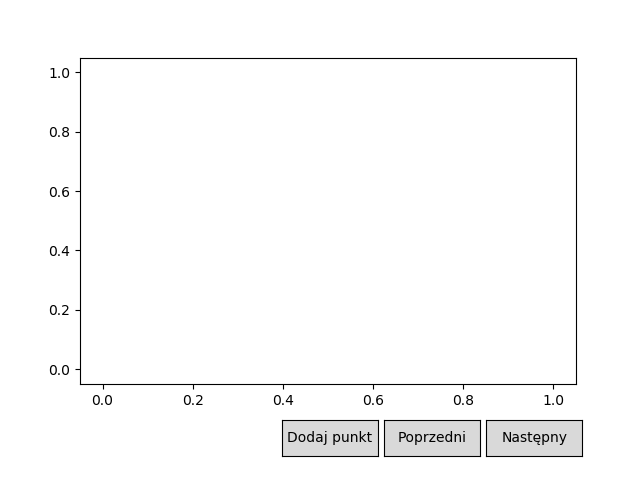

In [3]:
# Interaktywne wprowadzanie punktów
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [4]:
plot2 = Plot([plot1.get_added_elements()])    
data = js.loads(plot2.toJson())
if data[0]["points"]:
    if sets:
        if desc[0] == "Recznie":
            sets[0] = ([P for P in data[0]["points"][0]])
        else:
            sets.insert(0, [P for P in data[0]["points"][0]])
            desc.insert(0, "Recznie")
    else:
        sets = [[P for P in data[0]["points"][0]]]
        desc = ["Recznie"]
else:
    if sets and desc and desc[0] == "Recznie":
        sets.pop(0)
        desc.pop(0)

### Generowanie zbiorów
Przygotowane zostały procedury generujące zbiory punktów według następujących kryteriów: <br>
 - 1) Punkty generowane losowo w podanym zakresie<br>
 - 2) Punkty generowane losowo na zadanym okręgu<br>
 - 3) Punkty generowane losowo na bokach zadanego prostokąta<br>
 - 4) Punkty generowane losowo na prostej przechodzącej przez dane punkty A i B<br>
 
W pierwszym wierszu poniższej komórki można zmienić liczbę generowanych punktów. Przedziały i inne kryteria uwzględniane przy losowaniu punktów można także zmnienić osobno dla każdego zbioru w odpowiednich miejscach.

In [5]:
# Liczba generowanych punktów
num = 100

import random
import math

if sets and desc[0] == "Recznie":
    sets = [sets[0]]
    desc = [desc[0]]
else:
    sets = []
    desc = []

# Punkty generowane losowo w podanym zakresie
def gen_set1 (n = 100, xmin = -100, xmax = 100, ymin = -100, ymax = 100): 
    set1 = []
    for i in range(n):
        set1.append(((random.uniform(xmin, xmax)), (random.uniform(ymin, ymax))))
    return set1

sets.append(gen_set1(num))
desc.append("Losowo")

# Punkty generowano losowo na zadanym okręgu
def gen_set2 (n = 100, R = 10, ox = 0, oy = 0):  
    set2 = []
    for i in range(n):
        alpha = 2 * math.pi * random.random()
        x = R * math.cos(alpha) + ox
        y = R * math.sin(alpha) + oy
        set2.append((x, y))
    return set2

sets.append(gen_set2(num))
desc.append("Okrag")

# Punkty generowane losowo na bokach zadanego prostokąta
def gen_set3 (n = 100, P = [(-10, 10), (-10, -10), (10, -10), (10, 10)]):  
    set3 = [] 
    if (P[0][0] - P[1][0] == 0 or P[0][1] - P[1][1] == 0): # boki równoległe do osi ukł. wsp.
        T = [[P[0][0], P[0][1]], [P[0][0], P[0][1]]]
        for i in range(4):
            if (P[i][0] < T[0][0]):
                T[0][0] = P[i][0]
            if (P[i][1] < T[0][1]):
                T[0][1] = P[i][1]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
        P = [(T[0][0], T[0][1]), (T[1][0], T[0][1]), (T[1][0], T[1][1]), (T[0][0], T[1][1])]
        for i in range(n):
            l = random.randint(0, 3)
            if (l % 2 == 0):
                x = P[l][0] + random.random() * (P[l+1][0] - P[l][0])
                y = P[l][1]
            else:
                x = P[l][0]
                y = P[l][1] + random.random() * (P[(l+1) % 4][1] - P[l][1])
            set3.append((x, y))
    else: # dowolny prostokąt o bokach nierównoległych do osi ukł. wsp.
        a = []
        b = []
        for i in range(4):
            a.append((P[i][1] - P[(i+1) % 4][1]) / (P[i][0] - P[(i+1) % 4][0]))
            b.append(P[i][1] - P[i][0] * a[i])
        
        for i in range(n):
            l = random.randint(0, 3)
            x = P[l][0] + random.random() * (P[(l+1) % 4][0] - P[l][0])
            y = a[l] * x + b[l]
            set3.append((x, y))
    return set3

sets.append(gen_set3(num))
desc.append("Prostokat")

sets.append(gen_set3(num, [(0, 0), (1, -2), (4, 0), (3, 2)]))
desc.append("Krzywy prostokat")

# Punkty generowane losowo na prostej przechodzącej przez dane punkty A i B
def gen_set4(n = 100, A = [-1.0, 0.0], B = [1.0, 0.1], xmin = -100, xmax = 100):
    set4 = []
    a = (A[1] - B[1]) / (A[0] - B[0])
    b = A[1] - A[0] * a

    for i in range(n):
        x = random.uniform(xmin, xmax)
        y = a*x + b
        set4.append((x, y))
    return set4

sets.append(gen_set4(num))
desc.append("Prosta")

### Wizualizacja wszystkich zbiorów punktów
Aby zapisać lub wczytać dane z pliku, należy od/zakomentować odpowiedni kod.

<IPython.core.display.Javascript object>


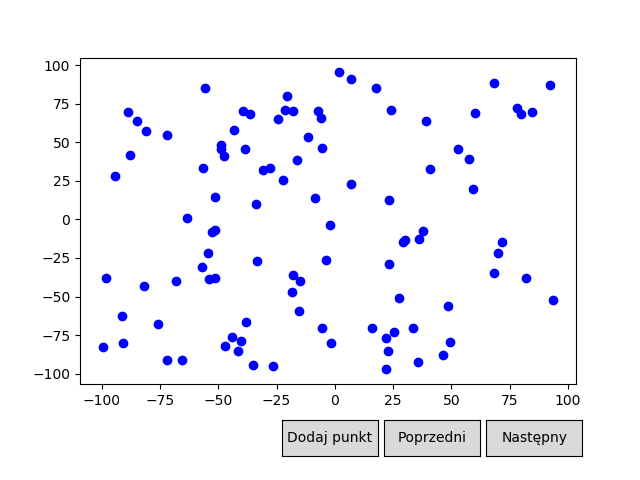

In [6]:
######### Ewentualny zapis do pliku ##########################################################
# with open('sets.json', 'w') as file:
#     dict_sets = {desc[i] : sets[i] for i in range(len(sets))}
#     file.write(js.dumps(dict_sets))
##############################################################################################
######### Ewentualne odczytanie z pliku ######################################################
# with open('sets.json', 'r') as file:
#     data = file.read()
# data = js.loads(data)
# desc = [x for x in data]
# sets = [data[x] for x in data]
###############################################################################################

scenes = [Scene([PointsCollection(set, color = 'blue')]) for set in sets]

plot = Plot(scenes)
plot.draw() 

## Minimalny okrąg

### Funkcje pomocnicze

In [7]:
# Okrąg na wizualizacji będzie składał się z tylu odcinków
CIRCLE_PREC = 100   
eps = 10 ** (-10)

import datetime

# Funkcja zwracająca okrąg (właściwie - listę odcinków)
def circle_segments(D): 
    S = D[0]
    r = D[1]
    theta = np.linspace(0, 2*np.pi, 100)
    x = S[0] + r*np.cos(theta)
    y = S[1] + r*np.sin(theta)
    lines = [[[x[i], y[i]], [x[(i + 1) % CIRCLE_PREC], y[(i + 1) % CIRCLE_PREC]]] for i in range(CIRCLE_PREC)]
    return lines

# Odległość między 2 punktami
def dist(A, B):  
    return math.sqrt((A[0] - B[0]) ** 2 + (A[1] - B[1]) ** 2)

# dla |R| <= 3 funkcja zwraca środek i promień takiego koła, które zawiera zadane punkty i jest możliwie najmniejsze.
def build_circle(R, is_skyum = False): 
    if not R:          # Dla 0 punktów - None
        return None
    elif len(R) == 1:  # Dla 1 punktu - okrąg o promieniu 0
        return (R[0], 0)
    elif len(R) == 2:  # Dla 2 punktów - okrąg o środku w połowie odcinka i promieniu równym połowie jego długości
        S = ((R[0][0] + R[1][0]) / 2, (R[0][1] + R[1][1]) / 2)
        r = dist(S, R[1])
        return (S, r)
    else:              # Dla 3 punktów:
        A = R[0]
        B = R[1]
        C = R[2]
        if is_skyum == False:
            a = [(dist(A, B), A, B), (dist(B, C), B, C), (dist(C, A), C, A)]
            a.sort(key = lambda k : k[0])
            if a[0][0] ** 2 + a[1][0] ** 2 < a[2][0] ** 2:  # Trójkąt rozwartokątny - brane pod uwagę są tylko dwa
                S = ((a[2][1][0] + a[2][2][0]) / 2, (a[2][1][1] + a[2][2][1]) / 2)  # punkty najdłuższego boku
                r = dist(S, a[2][1])
                return (S, r)

    if B[1] - A[1] != 0: # W przeciwnym wypadku - okrąg opisany na danych trzech punktach
        a1 = - ((B[0] - A[0]) / (B[1] - A[1]))
        b1 = (A[1] + B[1]) / 2 - a1 * (A[0] + B[0]) / 2
    else:
        a1 = - ((B[0] - C[0]) / (B[1] - C[1]))
        b1 = (C[1] + B[1]) / 2 - a1 * (C[0] + B[0]) / 2

    if C[1] - A[1] != 0:
        a2 = - ((C[0] - A[0]) / (C[1] - A[1]))
        b2 = (A[1] + C[1]) / 2 - a2 * (A[0] + C[0]) / 2
    else:
        a2 = - ((C[0] - B[0]) / (C[1] - B[1]))
        b2 = (B[1] + C[1]) / 2 - a2 * (B[0] + C[0]) / 2

    if a1 - a2 != 0:
        xs = (b2 - b1) / (a1 - a2)
    else:
        xs = 0
    ys = a1 * xs + b1
    S = (xs, ys)
    r = dist(S, A)
    return (S, r)

# Zwraca True, gdy punkt p leży we wnętrzu koła D; wpp. False
def includes(D, p): 
    if D == None:
        return False
    S = D[0]
    r = D[1]
    if (p[0] - S[0]) ** 2 + (p[1] - S[1]) ** 2 <= r ** 2 + eps:
        return True
    else:
        return False

# Losowy wybór punktu z danego zbioru (zwraca indeks)
def choose_random(P):  
    p = P[random.randint(0, len(P) - 1)]
    return p

# Zwraca promień okręgu opisanego na A, B, C
def radius(A, B, C):
    if A == C:
        return dist(A, B) / 2
    else:
        return build_circle([A, B, C], True)[1]

# Zwraca kąt pomiędzy odcinkami AB i AC
def angle(A, B, C, R):
    if A == C:
        return 90
    else:
        a = dist(A, B)
        c = dist(B, C)
        b = dist(A, C)
        cos = (a*a + c*c - b*b) / (2 * a * c)
        return np.arccos(cos) * 180 / np.pi

#### Algorym Grahama obliczający otoczkę wypukłą

In [8]:
import copy
from functools import cmp_to_key

# Znajduje punkt o najmniejszej współrzędnej x-owej z punktów o najmniejszej współrzędnej y-owej
def find_lower_left(set):
    result = 0
    for i in range(len(set)):
        if set[i][1] < set[result][1]:
            result = i
    for i in range(len(set)):
        if set[i][1] == set[result][1] and set[i][0] < set[result][0]:
            result = i
    return result

# Oblicza odpowiedni wyznacznik w celu określenia, po której stronie prostej AB znajduje się punkt C
def det(A, B, C):
    return A[0]*B[1] + B[0]*C[1] + C[0]*A[1] - C[0]*B[1] - A[0]*C[1] - B[0]*A[1]

# Zwraca 1, 0 albo -1 w zależności od znaku wyznacznika
def orient(A, B, C):
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0
    
# Bazuje na orient, ale rozróżnia kilka przypadków, gdy obliczony wyznacznik jest równy 0
def orient_ext(A, B, C):
    if A == B:
        return 1
    if A == C:
        return -1
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        if C[1] > B[1]:
            return -1
        elif B[1] > C[1]:
            return 1
        else:
            if C[0] > B[0]:
                return -1
            else:
                return 1

# Sortuje punkty ze zbioru po kącie w stosunku do punktu A
def orient_sort(set, A):
    set.sort(key = cmp_to_key(lambda B, C : orient_ext(A, C, B)))

# Algorytm Grahama do znajdowania otoczki wypukłej; Zwraca listę punktów otoczki
def convex_hull(set):
    S = copy.deepcopy(set)
    start = find_lower_left(S)
    A = S[start]
    orient_sort(S, A)
    
    stack = [0, 1]
    for i in range(2, len(S)):
        while(True):
            A = stack[-2]
            B = stack[-1]
            C = i
            if orient(S[A], S[B], S[C]) == 1:
                stack.append(C)
                break
            else:
                stack.pop()
                if orient(S[0], S[B], S[C]) == 0:
                    if S[C][1] > S[B][1]:
                        stack.append(C)
                    elif S[C][1] < S[B][1]:
                        stack.append(B)
                    else:
                        if S[C][0] > S[B][0]:
                            stack.append(C)
                        else:
                            stack.append(B)
                    break
    if len(stack) > 2 and orient(S[0], S[-2], S[-1]) == 0:
        stack.pop(-1)
    result = [S[stack[i]] for i in range(len(stack))]
    return result

### Algorytm Brute Force
Złożoność czasowa: <em>O(n<sup>4</sup>)</em><br>
Algorytm dla każdej trójki punktów sprawdza okrąg opisany na nich za pomocą funkcji <em>build_circle</em>.

In [9]:
def smallest_circle_bf(P):
    result = None
    for i in range(len(P)):
        for j in range(i + 1, len(P)):
            for k in range(j + 1, len(P)):
                D = build_circle([P[i], P[j], P[k]])
                to_check = True
                for p in P:
                    if not includes(D, p):
                        to_check = False
                        break
                if to_check:
                    if result == None:
                        result = D
                    else:
                        if result[1] > D[1]:
                            result = D
    return result

#### Czasy działania algorytmu Brute Force
Czasy racjonalne dla zbiorów o liczności nie większej niż <em>num = 200</em>.

In [10]:
# durations = []
# for set in sets:
#     start = datetime.datetime.now()
#     smallest_circle_bf(set)
#     duration = datetime.datetime.now() - start
#     durations.append((duration.seconds * 1000000 + duration.microseconds) / 1000)
    
# print("Czasy działania dla zbiorów wygenerowanych zawierających", num, "punktów:")
# for i in range(len(sets)):
#     print(i + 1, ": ", "%16s"%desc[i], " - ", "%5i"%durations[i], " ms", sep = '')

### Algorytm Skyuma
Opis: https://tidsskrift.dk/daimipb/article/view/6704 <br>
Złożoność czasowa przy zastosowaniu odpowiednich struktur (np. zmodyfikowanej kolejki priorytetowej): <em>O(nlogn)</em><br>
W tym przypadku złożoność oczekiwana: <em>O(nlogn)</em> (osiągnięta gdy rozmiar otoczki <em>h = o(n)</em>), złożoność najgorsza <em>O(n<sup>2</sup>)</em><br>

In [11]:
# Przygotowuje tablice promieni i kątów opisanych na kolejnych trzech punktach z otoczki wypukłej
def prepare_skyum_tabs(S):
    radii = [None] * len(S)
    angles = [None] * len(S)
    for i in range(0, len(S)):
        radii[i] = radius(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)])
        angles[i] = angle(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)], radii[i])
    return (radii, angles)

# Po usunięciu wierzchołka z otoczki wypukłej, aktualizuje wartości promieni i kątów dla sąsiadów usuniętego punktu
def update_skyum_tabs(S, radii, angles, p):
    S.pop(p)
    radii.pop(p)
    angles.pop(p)
    i = p % len(S)
    radii[i] = radius(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)])
    angles[i] = angle(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)], radii[i])
    i = (p - 1) % len(S)
    radii[i] = radius(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)])
    angles[i] = angle(S[(i - 1) % len(S)], S[i], S[(i + 1) % len(S)], radii[i])

# Zwraca kolejny punkt do rozpatrywania
def find_next_skyum(S, radii, angles):
    res_rad = 0
    res_ang = 0
    res_i = 0
    for i in range(0, len(S)):
        if radii[i] > res_rad:
            res_i = i
            res_rad = radii[i]
            res_ang = angles[i]
        if radii[i] == res_rad:
            if angles[i] > res_ang:
                res_i = i
                res_rad = radii[i]
                res_ang = angles[i]
    return (res_i, res_ang)

# Właściwy algorytm
def smallest_circle_s(P):
    S = convex_hull(P)
    (radii, angles) = prepare_skyum_tabs(S)
    while True:
        (p, ang) = find_next_skyum(S, radii, angles)
        if ang <= 90:
            if len(S) > 2:
                return build_circle([S[(p - 1) % len(S)], S[p], S[(p + 1) % len(S)]])
            else:
                return build_circle([S[p], S[(p + 1) % len(S)]])
        else:
            update_skyum_tabs(S, radii, angles, p)

#### Czasy działania algorytmu Skyuma

In [12]:
# durations = []
# for set in sets:
#     start = datetime.datetime.now()
#     smallest_circle_s(set)
#     duration = datetime.datetime.now() - start
#     durations.append((duration.seconds * 1000000 + duration.microseconds) / 1000)
    
# print("Czasy działania dla zbiorów wygenerowanych zawierających", num, "punktów:")
# for i in range(len(sets)):
#     print(i + 1, ": ", "%16s"%desc[i], " - ", "%5i"%durations[i], " ms", sep = '')

### Algorytm Welzla
Opis: https://en.wikipedia.org/wiki/Smallest-circle_problem <br>
Oczekiwana złożoność czasowa: <em>O(n)</em><br>
Ze względu na dużą liczbę wywołań rekurencyjnych, szybko zostaje przekroczona maksymalna głębokość rekursji i algorytm przestaje działać. Nie zalecanym jest uruchamianie algorytmu dla zbiorów o liczności większej niż <em>n = 2900</em>.

In [13]:
def smallest_circle_w(P):
    return __smallest_circle_w(P, [])

def __smallest_circle_w(P, R):
    if not P or len(R) == 3:
        return build_circle(R)
    p = choose_random(P)
    P2 = [k for k in P if k != p]
    D = __smallest_circle_w(P2, R)
    if includes(D, p):
        return D
    else:
        return __smallest_circle_w(P, R + [p])

#### Czasy działania algorytmu Welzla

In [14]:
# durations = []
# for set in sets:
#     start = datetime.datetime.now()
#     smallest_circle_w(set)
#     duration = datetime.datetime.now() - start
#     durations.append((duration.seconds * 1000000 + duration.microseconds) / 1000)
    
# print("Czasy działania dla zbiorów wygenerowanych zawierających", num, "punktów:")
# for i in range(len(sets)):
#     print(i + 1, ": ", "%16s"%desc[i], " - ", "%5i"%durations[i], " ms", sep = '')

### Wizualizacja wyniku

<IPython.core.display.Javascript object>


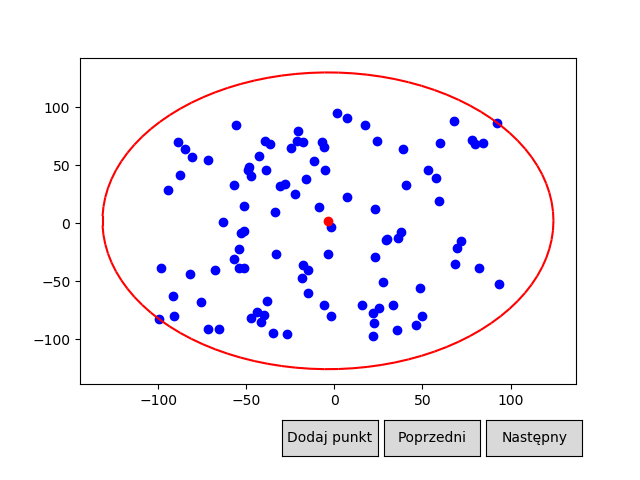

In [15]:
scenes = []
for set in sets:
    D = smallest_circle_s(set)
    scenes.append(Scene([PointsCollection(set, color = 'blue'),
                         PointsCollection([D[0]], color = 'red')],
                        [LinesCollection(circle_segments(D), color = 'red')]))

plot = Plot(scenes)
plot.draw() 

### Wizualizacja działania algorytmu Skyuma

<IPython.core.display.Javascript object>


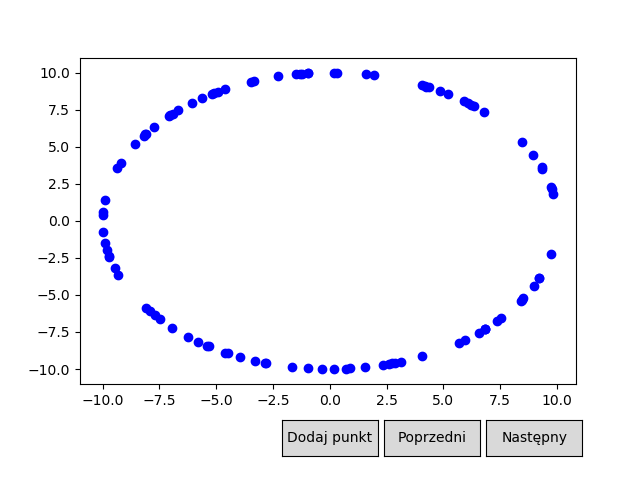

In [16]:
# Wybór zbioru:
set = sets[1]

scenes = [Scene([PointsCollection(set, color = 'blue')])]

def smallest_circle_s_vis(P):
    S = convex_hull(P)
    (radii, angles) = prepare_skyum_tabs(S)
    S_old = copy.deepcopy(S)
    
    scenes.append(Scene([PointsCollection([s for s in S], color = 'blue')]))
    
    while True:
        (p, ang) = find_next_skyum(S, radii, angles)
        scenes.append(Scene([PointsCollection([s for s in S_old], color = 'cadetblue'),
                             PointsCollection([s for s in S], color = 'blue'),
                             PointsCollection([S[p]], color = 'red'),
                             PointsCollection([S[(p - 1) % len(S)], S[(p + 1) % len(S)]], color = 'green')],
                            [LinesCollection([[S[(p - 1) % len(S)], S[p]], [S[p], S[(p + 1) % len(S)]]],color = 'green')]))
        if ang <= 90:
            if len(S) > 2:
                return build_circle([S[(p - 1) % len(S)], S[p], S[(p + 1) % len(S)]])
            else:
                return build_circle([S[p], S[(p + 1) % len(S)]])
        else:
            update_skyum_tabs(S, radii, angles, p)
            
D = smallest_circle_s_vis(set)

scenes.append(Scene([PointsCollection(set, color = 'blue'),
                     PointsCollection([D[0]], color = 'red')],
                    [LinesCollection(circle_segments(D), color = 'red')]))

plot = Plot(scenes)
plot.draw() 

#### Opis wizualizacji
Po utworzeniu otoczki wypukłej, znajdowane przez funkcję <em>find_next_skyum</em> punkty oznaczane są na czerwono, a ich sąsiedzi na zielono. Jasnoniebieskie punkty zostały usunięte ze zbioru <em>S</em> w trakcie działania algorytmu.

### Wizualizacja działania algorytmu Welzla

<IPython.core.display.Javascript object>


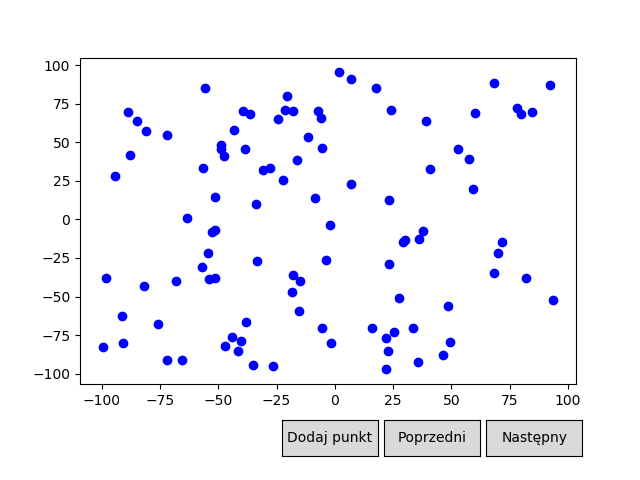

In [17]:
# Wybór zbioru:
set = sets[0]

scenes = [Scene([PointsCollection(set, color = 'blue')])]

def smallest_circle_w_vis(P):
    return __smallest_circle_w_vis(P, [])

def __smallest_circle_w_vis(P, R):
    if not P or len(R) == 3:
        D = build_circle(R)
        return build_circle(R)
    p = choose_random(P)
    P2 = [k for k in P if k != p]
    D = __smallest_circle_w_vis(P2, R)
    
    scenes.append(Scene([PointsCollection(set, color = 'steelblue'),
                         PointsCollection([D[0]] if D else [], color = 'red')],
                        [LinesCollection(circle_segments(D) if D else [], color = 'red')]))

    scenes.append(Scene([PointsCollection(set, color = 'steelblue'),
                         PointsCollection([D[0]] if D else [], color = 'red'),
                         PointsCollection([p], color = 'orange')],
                        [LinesCollection(circle_segments(D) if D else [], color = 'red')]))
    
    if includes(D, p):
        
        scenes.append(Scene([PointsCollection(set, color = 'steelblue'),
                             PointsCollection([D[0]] if D else [], color = 'red'),
                             PointsCollection([p], color = 'green')],
                            [LinesCollection(circle_segments(D) if D else [], color = 'red')]))
        
        return D
    else:
        
        scenes.append(Scene([PointsCollection(set, color = 'steelblue'),
                             PointsCollection([D[0]] if D else [], color = 'red'),
                             PointsCollection([p], color = 'black')],
                            [LinesCollection(circle_segments(D) if D else [], color = 'red')]))
        
        return __smallest_circle_w_vis(P2, R + [p])
                
D = smallest_circle_w_vis(set)
                
scenes.append(Scene([PointsCollection(set, color = 'blue'),
                     PointsCollection([D[0]], color = 'red')],
                    [LinesCollection(circle_segments(D), color = 'red')]))
    
plot = Plot(scenes)
plot.draw() 

#### Opis wizualizacji
Okręgi zaznaczone są na czerwono. Sprawdzany punkt ma kolor żółty; jeśli należy do aktualnie badanego okręgu, jego kolor zmieniany jest na czerwony, w przeciwnym wypadku - na czarny.

## Minimalne prostokąty

### Funkcje pomocnicze

In [18]:
# Niektóre funkcje zaimplementowane wyżej także są wymagane
import sys

# Znajduje granice (najmniejsze i największe współrzędne) dla danego zbioru punktów
def find_boundaries(S):
    (xmin, xmax, ymin, ymax) = (0, 0, 0, 0)
    for s in S:
        xmin = min(s[0], xmin)
        xmax = max(s[0], xmax)
        ymin = min(s[1], ymin)
        ymax = max(s[1], ymax)
    return (xmin, xmax, ymin, ymax)

# Znajduje proste wchodzące w skład tworzonego przez funkcję minimum_rectangles prostokąta
def find_lines(S, A, B):
    a1 = (A[1] - B[1]) / (A[0] - B[0])
    a2 = -1 / a1
    
    b1_min = sys.maxsize
    b1_max = -sys.maxsize
    b2_min = sys.maxsize
    b2_max = -sys.maxsize
    
    for s in S:
        b1 = s[1] - a1 * s[0]
        b2 = s[1] - a2 * s[0]
        b1_min = min(b1, b1_min)
        b1_max = max(b1, b1_max)
        b2_min = min(b2, b2_min)
        b2_max = max(b2, b2_max)
    return [[a1, a2, a1, a2], [b1_min, b2_max, b1_max, b2_min]]

# Przyjmuje współczynniki równań czterech prostych i znajduje ich przecięcia (wierzchołki pristokąta)
def find_corners(a, b):
    corners = []
    for i in range(4):
        a1 = a[(i - 1) % 4]
        b1 = b[(i - 1) % 4]
        a2 = a[i]
        b2 = b[i]
        x = (b2 - b1) / (a1 - a2)
        y = a1 * x + b1
        corners.append([x, y])
    return corners

# Oblicza pole danego prostokąta
def find_area(corners):
    return dist(corners[0], corners[1]) * dist(corners[0], corners[3])

# Oblicza obwód danego prostokąta
def find_perimeter(corners):
    return 2 * dist(corners[0], corners[1]) + 2 * dist(corners[0], corners[3])

### Algorytm według podejścia rotating calipers
opis: https://en.wikipedia.org/wiki/Rotating_calipers<br>
Złożoność czasowa: <em>O(nlogn)</em><br>
Jeżeli dany zbiór tworzy wielokąt wypukły, można zrezygnować z szukania otoczki wypukłej otrzymując złożoność czasową <em>O(n)</em><br>
Algorytm zwraca punkty utworzonych prostokątów o najmniejszym polu oraz o najmiejszym obwodzie, zawierających wszystkie punkty zadanych zbiorów.

In [19]:
def minimum_rectangles(P):
    S = convex_hull(P)
    S.append(S[0])
    
    min_area = [sys.maxsize]
    min_perimeter = [sys.maxsize]
    
    for i in range(len(S) - 1):
        A = S[i]
        B = S[i + 1]
        if A[0] == B[0] or A[1] == B[1]:
            (xmin, xmax, ymin, ymax) = find_boundaries(S)
            area = (xmax - xmin) * (ymax - ymin)
            perimeter = 2 * (xmax - xmin) + 2 * (ymax - ymin)
            if area < min_area[0]:
                min_area = [area, [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]]
            if perimeter < min_perimeter[0]:
                min_perimeter = [area, [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]]
        else:
            (a, b) = find_lines(S, A, B)
            corners = find_corners(a, b)
            area = find_area(corners)
            perimeter = find_perimeter(corners)
            if area < min_area[0]:
                min_area = [area, corners]
            if perimeter < min_perimeter[0]:
                min_perimeter = [perimeter, corners]
    return (min_area[1], min_perimeter[1])

#### Czasy działania algorytmu

In [20]:
# durations = []
# for set in sets:
#     start = datetime.datetime.now()
#     minimum_rectangles(set)
#     duration = datetime.datetime.now() - start
#     durations.append((duration.seconds * 1000000 + duration.microseconds) / 1000)
    
# print("Czasy działania dla zbiorów wygenerowanych zawierających", num, "punktów:")
# for i in range(len(sets)):
#     print(i + 1, ": ", "%16s"%desc[i], " - ", "%5i"%durations[i], " ms", sep = '')

### Wizualizacja wyników

<IPython.core.display.Javascript object>


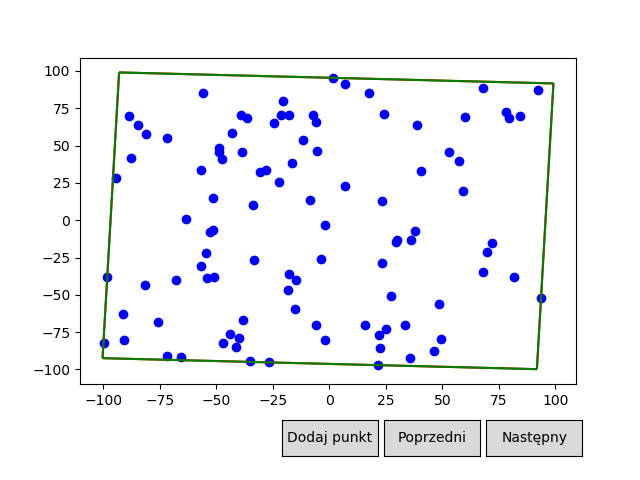

In [21]:
scenes = []
for set in sets:
    (min_area, min_perimeter) = minimum_rectangles(set)
    scenes.append(Scene([PointsCollection(set, color = 'blue')],
                    [LinesCollection([[min_area[i], min_area[(i + 1) % 4]] for i in range(4)], color = 'red'),
                     LinesCollection([[min_perimeter[i], min_perimeter[(i + 1) % 4]] for i in range(4)],
                                     color = 'green')]))
plot = Plot(scenes)
plot.draw() 

#### Opis wizualizacji
Na czerwono zaznaczone są prostokąty o najmniejszym polu, natomiast na zielono - prostokąty o najmniejszym obwodzie. Wyświetlenie się jednego prostokąta oznacza, że poszukiwane prostokąty są identyczne.

### Wizualizacja działania algorytmu
Wizualizacja oparta jest na szukaniu prostokąta o najmniejszym polu. Algorytm jednak jest taki sam, jak w przypadku najmniejszego obwodu.

<IPython.core.display.Javascript object>


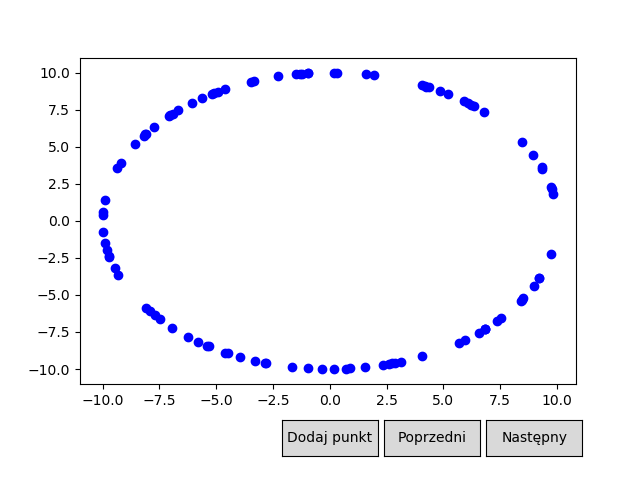

In [22]:
# Wybór zbioru:
set = sets[1]

scenes = [Scene([PointsCollection(set, color = 'blue')])]

def minimum_rectangles_vis(P):
    S = convex_hull(P)
    S.append(S[0])
    
    min_area = [sys.maxsize]
    
    for i in range(len(S) - 1):
        A = S[i]
        B = S[i + 1]
        if A[0] == B[0] or A[1] == B[1]:
            (xmin, xmax, ymin, ymax) = find_boundaries(S)
            area = (xmax - xmin) * (ymax - ymin)
            p_area = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
            
            scenes.append(Scene([PointsCollection(set, color = 'cadetblue'),
                                 PointsCollection(S, color = 'blue'),
                                 PointsCollection([A, B], color = 'red')],
                    [LinesCollection([[p_area[1][i], p_area[1][(i + 1) % 4]] for i in range(4)], color = 'red')]))
            
            if area < min_area[0]:
                
                scenes.append(Scene([PointsCollection(set, color = 'cadetblue'),
                                     PointsCollection(S, color = 'blue'),
                                     PointsCollection([A, B], color = 'green')],
                    [LinesCollection([[p_area[1][i], p_area[1][(i + 1) % 4]] for i in range(4)], color = 'green')]))
                
                min_area = [area, p_area]
        else:
            (a, b) = find_lines(S, A, B)
            corners = find_corners(a, b)
            area = find_area(corners)
            scenes.append(Scene([PointsCollection(set, color = 'cadetblue'),
                                 PointsCollection(S, color = 'blue'),
                                 PointsCollection([A, B], color = 'red')],
                    [LinesCollection([[corners[i], corners[(i + 1) % 4]] for i in range(4)], color = 'red')]))
            
            if area < min_area[0]:
                
                scenes.append(Scene([PointsCollection(set, color = 'cadetblue'),
                                     PointsCollection(S, color = 'blue'),
                                     PointsCollection([A, B], color = 'green')],
                    [LinesCollection([[corners[i], corners[(i + 1) % 4]] for i in range(4)], color = 'green')]))
                
                min_area = [area, corners]
    return min_area[1]

min_area = minimum_rectangles_vis(set)

scenes.append(Scene([PointsCollection(set, color = 'blue')],
                    [LinesCollection([[min_area[i], min_area[(i + 1) % 4]] for i in range(4)], color = 'green')]))

plot = Plot(scenes)
plot.draw() 

#### Opis wizualizacji
Wierzchołki, które nie należą do otoczki wypukłej stają się jasnoniebieskie. Algorytm przechodzi "dookoła" po otoczce wypukłej i konstruowane są prostokąty (kolor czerwony). Jeżeli aktualnie wyświetlony prostokąt jest dotychczas minimalny, jest on kolorowany na zielono. Ostatecznie, docelowy prostokąt wyświetlany jest na zielono.